In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import sys
sys.path.append('../src')
from utils.config_parser import load_config as cfg


sns.set()
warnings.simplefilter('ignore')

In [2]:
data_config = cfg(os.path.join('..','config','data_config.yaml'))
credit_card_path = data_config.get('raw_data_paths', None).get('credit_card_fraud', None)
df = pd.read_csv(os.path.join('..',credit_card_path))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.isnull().sum().to_frame(name='null_count')

,null_count
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [4]:
df_old = df.copy()

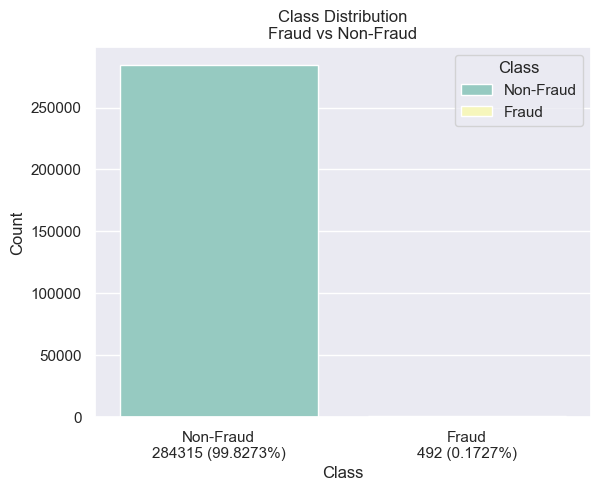

In [5]:
d_length = df.shape[0]
fraud_count = df['Class'].sum()
n_fraud_count = d_length - fraud_count

percent_fraud = (fraud_count / d_length) * 100
percent_nfraud = 100 - percent_fraud

ax = sns.countplot(x='Class', data=df, palette='Set3')
plt.title('Class Distribution\nFraud vs Non-Fraud')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.xticks([0, 1], [f'Non-Fraud\n{n_fraud_count} ({percent_nfraud:.4f}%)', f'Fraud\n{fraud_count} ({percent_fraud:.4f}%)'])
plt.show()

## Feature Engineering

In [6]:
df = df.drop(columns=["Time"])
print("Dropped 'Time'.")

Dropped 'Time'.


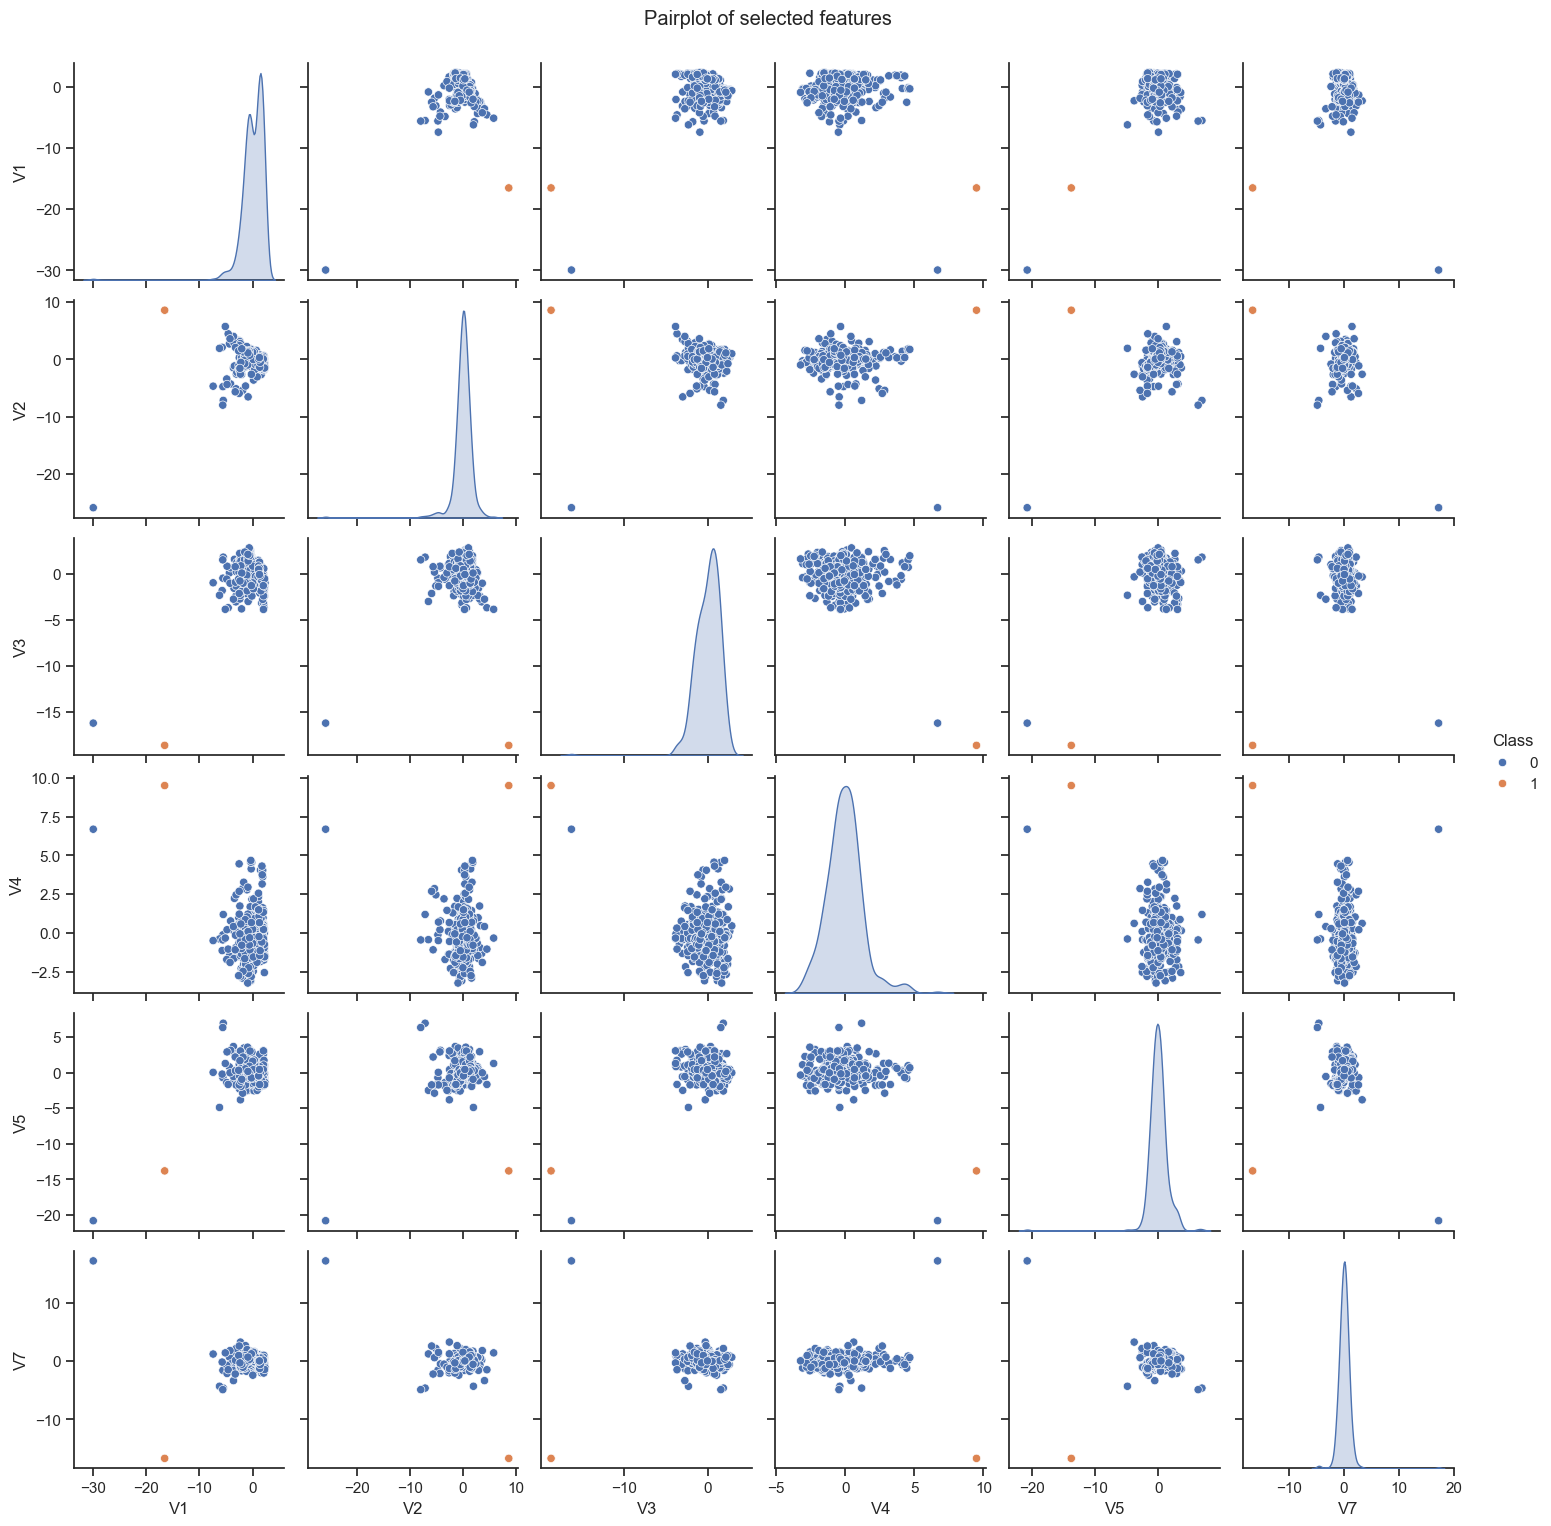

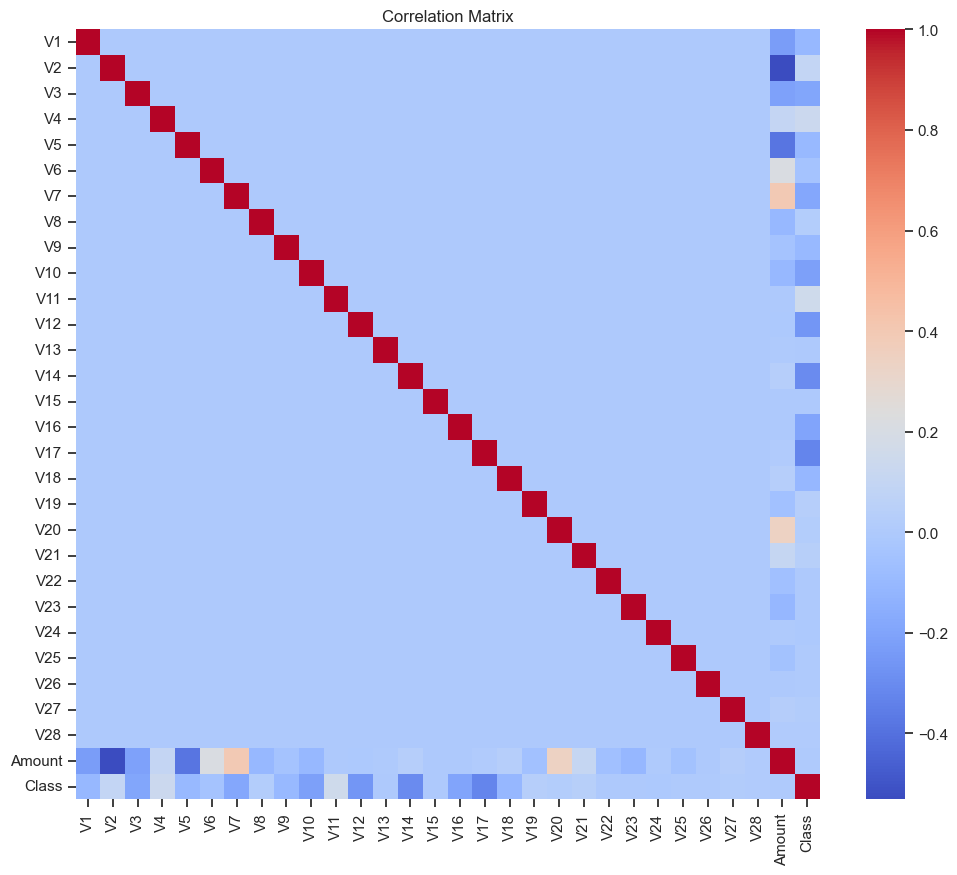

In [7]:
cm = sns.set_theme(style="ticks")
cm = sns.pairplot(df.sample(n=500, random_state=42), hue='Class', vars=['V1', 'V2', 'V3', 'V4', 'V5', 'V7'])
plt.suptitle('Pairplot of selected features', y=1.02)
plt.show()

plt.figure(figsize=(12, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Split Data

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'], errors='ignore')
y = df['Class']

train_ratio = data_config['data_ratios']['train']
val_ratio = data_config['data_ratios']['validation']
test_ratio = data_config['data_ratios']['test']
random_state = data_config['data_ratios']['random_state']
stratify_by = data_config['data_ratios']['stratify']
target_column = 'Class'

In [9]:
# First split: Training + Validation vs. Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_ratio, random_state=random_state, stratify=y if stratify_by else None
        )

relative_val_ratio = val_ratio / (train_ratio + val_ratio)
# Second split: Training vs. Validation
X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=relative_val_ratio, random_state=random_state, stratify=y_train_val if stratify_by else None
        )

In [10]:
print(f"Train set shape: {X_train.shape}, Fraud: {y_train.sum()} ({y_train.mean():.4f}%)")
print(f"Validation set shape: {X_val.shape}, Fraud: {y_val.sum()} ({y_val.mean():.4f}%)")
print(f"Test set shape: {X_test.shape}, Fraud: {y_test.sum()} ({y_test.mean():.4f}%)")
print("Data splitting complete.")

Train set shape: (199364, 29), Fraud: 344 (0.0017%)
Validation set shape: (42721, 29), Fraud: 74 (0.0017%)
Test set shape: (42722, 29), Fraud: 74 (0.0017%)
Data splitting complete.


## Scale Feature

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical_features = X_train.columns.tolist()

scaling_method = data_config['preprocessing_params'].get('scaling_method', 'StandardScaler')
print(f"Scaling numerical features using: {scaling_method}...")

if scaling_method == "StandardScaler":
    scaler = StandardScaler()
elif scaling_method == "MinMaxScaler":
    scaler = MinMaxScaler()
elif scaling_method is None:
    print("No scaling applied.")
else:
    raise ValueError(f"Unsupported scaling method: {scaling_method}")

# Fit scaler only on training data to prevent data leakage
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

Scaling numerical features using: StandardScaler...


## Handling Imbalance

In [12]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

if not data_config.get('preprocessing_params', False).get('handle_imbalanced_data', False):
    print('Imbalance handling not enabled in config. Skipping this step.')
    exit()

imbalance_method = data_config['preprocessing_params'].get('imbalance_method', 'SMOTE')

if imbalance_method == "SMOTE":
    sampling_strategy = data_config['preprocessing_params'].get('smote_sampling_strategy')
    sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)

elif imbalance_method == "ADASYN":
    sampler = ADASYN(random_state=random_state)
elif imbalance_method == "RandomUnderSampler":
    # Be cautious with undersampling as it discards data
    sampler = RandomUnderSampler(random_state=random_state)
elif imbalance_method == "None":
    print("No resampling applied, but imbalance handling is enabled.")
else:
    raise ValueError(f"Unsupported imbalance method: {imbalance_method}")

X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
print(f"Original training data shape: {X_train.shape}, {y_train.value_counts()}")
print(f"Resampled training data shape: {X_resampled.shape}, {y_resampled.value_counts()}")
print("Imbalance handling complete.")


Original training data shape: (199364, 29), Class
0    199020
1       344
Name: count, dtype: int64
Resampled training data shape: (398040, 29), Class
0    199020
1    199020
Name: count, dtype: int64
Imbalance handling complete.


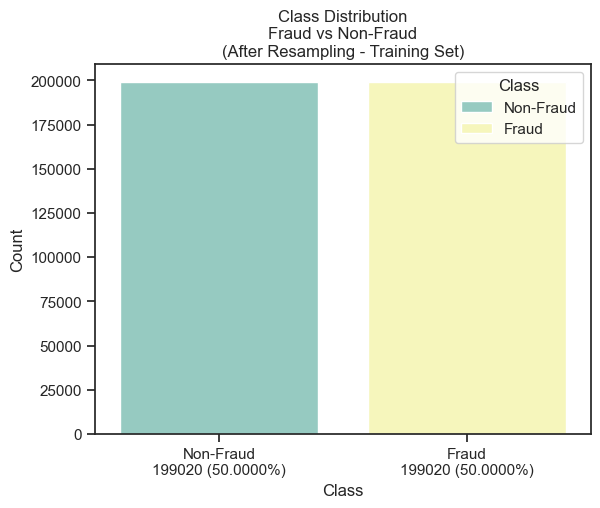

In [13]:
d_length = len(y_resampled)
fraud_count = pd.DataFrame(y_resampled)['Class'].sum()
n_fraud_count = d_length - fraud_count

percent_fraud = (fraud_count / d_length) * 100
percent_nfraud = 100 - percent_fraud

ax = sns.countplot(x='Class', data=pd.DataFrame(y_resampled), palette='Set3')
plt.title('Class Distribution\nFraud vs Non-Fraud\n(After Resampling - Training Set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.xticks([0, 1], [f'Non-Fraud\n{n_fraud_count} ({percent_nfraud:.4f}%)', f'Fraud\n{fraud_count} ({percent_fraud:.4f}%)'])
plt.show()